**FBE 551 - Final Project**

**Data Imports and Cleaning**

In [1]:
# Imports

import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd

stocks = pd.read_feather('crsp_monthly_stocks2.feather')
cstat  = pd.read_feather('compustat_annual.feather')
financials = pd.read_csv('rwwwph5pgksjjttg.csv')

In [2]:
# Get reference returns -> Market Return
ff = pd.read_csv('FFdata.csv')
ff['DATE'] = pd.to_datetime(ff['Date'].astype(str), format='%Y%m') + MonthEnd(0)
ff.set_index(['DATE'], inplace=True)
ff['MKT'] = ff['Mkt-RF'] + ff['RF']
ref_returns = (ff.loc['2000-01-01':'2023-06-30']['MKT']/100)
rf_returns = (ff.loc['2000-01-01':'2023-06-30']['RF']/100)
mkt_rf_returns = (ff.loc['2000-01-01':'2023-06-30']['Mkt-RF']/100)

In [3]:
# Clean CRSP Data

stocks['DATE'] = stocks['DATE'] + MonthEnd(0)
stocks['PRC']  = np.abs(stocks['PRC'])
stocks['MV'] = stocks['SHROUT']*stocks['PRC']
stocks.drop(['SHRCD','EXCHCD','SICCD'], axis=1, inplace=True)
stocks.set_index(['PERMNO','DATE'], inplace=True)
stocks.sort_index(inplace=True)

In [4]:
# Clean COMPUSTAT

cstat.rename(columns={"LPERMNO":"PERMNO"}, inplace=True)
cstat['DATE'] = cstat['DATADATE'] + MonthEnd(0)
cstat.set_index(['PERMNO','DATE'], inplace=True)
cstat.sort_index(inplace=True)

In [5]:
# Merge

stocks = stocks.sort_values(by = ['PERMNO','DATE','MV'], ascending = [True, True, False])
cstat  = cstat.sort_values(by = ['PERMNO','DATE','SEQ'], ascending = [True, True, False])

stocks = stocks.groupby(['PERMNO','DATE']).head(1)
cstat  = cstat.groupby(['PERMNO','DATE']).head(1)

stocks = stocks.merge(cstat[['IB','SEQ', 'DVT', 'SALE', 'CAPX', 'AT', 'CEQ', 'CHE', 'LT']], how='left', on=['PERMNO','DATE'])

In [6]:
# Lag and fill COMPUSTAT columns

stocks['lag IB'] = stocks['IB'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag SEQ'] = stocks['SEQ'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag DVT'] = stocks['DVT'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag SALE'] = stocks['SALE'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag CAPX'] = stocks['CAPX'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag AT'] = stocks['AT'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag CEQ'] = stocks['CEQ'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag CHE'] = stocks['CHE'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)
stocks['lag LT'] = stocks['LT'].groupby('PERMNO').shift(6).groupby('PERMNO').fillna(method='pad', limit=15)

In [7]:
# Merge in financials
financials = pd.read_csv('rwwwph5pgksjjttg.csv')
financials = financials.drop(['adate', 'qdate'], axis = 1)
financials.rename(columns={'public_date': 'DATE'}, inplace=True)
financials.rename(columns={'permno': 'PERMNO'}, inplace=True)
financials['DATE'] = pd.to_datetime(financials['DATE'])
financials.set_index(['PERMNO','DATE'], inplace=True)
financials = financials.sort_values(by = ['PERMNO','DATE','roa'], ascending = [True, True, False])
financials = financials.groupby(['PERMNO','DATE']).head(1)

stocks = stocks.merge(financials, how='left', on=['PERMNO','DATE'])

In [8]:
for feature in financials.columns.values:
    stocks[feature] = stocks[feature].groupby('PERMNO').fillna(method='pad', limit=15)

In [10]:
stocks.columns

Index(['PRC', 'VOL', 'RET', 'SPREAD', 'RETX', 'SHROUT', 'MV', 'IB', 'SEQ',
       'DVT', 'SALE', 'CAPX', 'AT', 'CEQ', 'CHE', 'LT', 'lag IB', 'lag SEQ',
       'lag DVT', 'lag SALE', 'lag CAPX', 'lag AT', 'lag CEQ', 'lag CHE',
       'lag LT', 'evm', 'roa', 'cash_debt', 'intcov_ratio', 'accrual_x',
       'CAPEI', 'bm', 'efftax', 'GProf', 'capital_ratio', 'invt_act',
       'cash_ratio', 'cash_conversion', 'at_turn', 'accrual_y'],
      dtype='object')

In [9]:
financials = pd.read_csv('oa8fpmvymtui3bld.csv')
financials = financials.drop(['adate', 'qdate'], axis = 1)
financials.rename(columns={'public_date': 'DATE'}, inplace=True)
financials.rename(columns={'permno': 'PERMNO'}, inplace=True)
financials['DATE'] = pd.to_datetime(financials['DATE'])
financials.set_index(['PERMNO','DATE'], inplace=True)
financials = financials.sort_values(by = ['PERMNO','DATE','capital_ratio'], ascending = [True, True, False])
financials = financials.groupby(['PERMNO','DATE']).head(1)

stocks = stocks.merge(financials, how='left', on=['PERMNO','DATE'])



KeyError: 'accrual'

In [13]:
stocks.rename(columns = {'accrual_x': 'accrual'}, inplace=True)
for feature in financials.columns.values:
    stocks[feature] = stocks[feature].groupby('PERMNO').fillna(method='pad', limit=15)


In [15]:
# stocks.columns = ['PRC', 'VOL', 'RET', 'SPREAD', 'RETX', 'SHROUT', 'MV', 'IB', 'SEQ',
#        'DVT', 'SALE', 'CAPX', 'AT', 'CEQ', 'CHE', 'LT', 'lag IB', 'lag SEQ',
#        'lag DVT', 'lag SALE', 'lag CAPX', 'lag AT', 'lag CEQ', 'lag CHE',
#        'lag LT', 'evm', 'roa', 'cash_debt', 'intcov_ratio', 'accrual',
#        'CAPEI', 'bm', 'efftax', 'GProf', 'capital_ratio', 'invt_act',
#        'cash_ratio', 'cash_conversion', 'at_turn', 'accrual_y']

stocks.columns

Index(['PRC', 'VOL', 'RET', 'SPREAD', 'RETX', 'SHROUT', 'MV', 'IB', 'SEQ',
       'DVT', 'SALE', 'CAPX', 'AT', 'CEQ', 'CHE', 'LT', 'lag IB', 'lag SEQ',
       'lag DVT', 'lag SALE', 'lag CAPX', 'lag AT', 'lag CEQ', 'lag CHE',
       'lag LT', 'evm', 'roa', 'cash_debt', 'intcov_ratio', 'accrual', 'CAPEI',
       'bm', 'efftax', 'GProf', 'capital_ratio', 'invt_act', 'cash_ratio',
       'cash_conversion', 'at_turn', 'accrual_y'],
      dtype='object')

In [16]:
# Further Cleaning

stocks_df = stocks.dropna(subset=['RET','MV','lag IB','lag SEQ','lag DVT','lag SALE','lag CAPX',
                               'lag AT','lag CEQ','lag CHE','lag LT'])#.extend(financials.columns.values))
stocks_df = stocks_df.drop(['SPREAD','RETX','IB','SEQ','DVT','SALE','CAPX','AT','CEQ','CHE','LT'], axis = 1)
stocks_df = stocks_df.reorder_levels(['DATE','PERMNO'])

stocks_df.sort_index(inplace=True)

MemoryError: Unable to allocate 1.03 GiB for an array with shape (40, 3452888) and data type float64

In [ ]:
stocks_df

PRC         VOL       RET     SHROUT            MV  \
DATE       PERMNO                                                               
1962-12-31 10516.0   41.750000       205.0  0.060317     1589.0  6.634075e+04   
           12669.0   16.625000       504.0 -0.057746     3033.0  5.042362e+04   
           22816.0   33.000000      1127.0 -0.057143     5277.0  1.741410e+05   
           26497.0    9.875000       306.0  0.007500     1284.0  1.267950e+04   
1963-01-31 10516.0   40.250000       153.0 -0.035928     1589.0  6.395725e+04   
...                        ...         ...       ...        ...           ...   
2023-06-30 93423.0   25.980000    461816.0  0.016830    83284.0  2.163718e+06   
           93426.0   37.150002     14546.0  0.063860    12577.0  4.672356e+05   
           93429.0  138.009995    139402.0  0.042214   105574.0  1.457027e+07   
           93434.0    1.220000      6626.0  0.150943    42964.0  5.241608e+04   
           93436.0  261.769989  34409322.0  0.283627  3169504.0  8.296810e+08   

                       lag IB    lag SEQ  lag DVT   lag SALE  lag CAPX  ...  \
DATE       PERMNO                                                       ...   
1962-12-31 10516.0      4.421     94.459    3.200    245.900    24.700  ...   
           12669.0      5.600     48.655    1.860    154.300     4.200  ...   
           22816.0     13.663    191.203    3.391    372.313    18.295  ...   
           26497.0      1.520      7.916    0.510     48.700     4.181  ...   
1963-01-31 10516.0      4.421     94.459    3.200    245.900    24.700  ...   
...                       ...        ...      ...        ...       ...  ...   
2023-06-30 93423.0    108.928   -950.565    0.000   1358.236   116.589  ...   
           93426.0     36.063    306.547    0.000    362.580    21.288  ...   
           93429.0    235.000   3465.300  209.400   3958.500    59.800  ...   
           93434.0    -36.395     56.172    0.167     71.354     2.099  ...   
           93436.0  12556.000  44704.000    0.000  81462.000  7163.000  ...   

                      CAPEI     bm  efftax  GProf  capital_ratio  invt_act  \
DATE       PERMNO                                                            
1962-12-31 10516.0      NaN    NaN     NaN    NaN            NaN       NaN   
           12669.0      NaN    NaN     NaN    NaN            NaN       NaN   
           22816.0      NaN    NaN     NaN    NaN            NaN       NaN   
           26497.0      NaN    NaN     NaN    NaN            NaN       NaN   
1963-01-31 10516.0      NaN    NaN     NaN    NaN            NaN       NaN   
...                     ...    ...     ...    ...            ...       ...   
2023-06-30 93423.0   23.599    NaN   0.224  0.240          1.631     0.138   
           93426.0   24.379  0.725   0.211  0.361          0.228     0.345   
           93429.0   30.747  0.284   0.300  0.225          0.346     0.000   
           93434.0   -3.655  1.499     NaN  0.053          0.290     0.705   
           93436.0  260.976  0.048   0.110  0.347          0.128     0.250   

                    cash_ratio  cash_conversion  at_turn  accrual_y  
DATE       PERMNO                                                    
1962-12-31 10516.0         NaN              NaN      NaN        NaN  
           12669.0         NaN              NaN      NaN        NaN  
           22816.0         NaN              NaN      NaN        NaN  
           26497.0         NaN              NaN      NaN        NaN  
1963-01-31 10516.0         NaN              NaN      NaN        NaN  
...                        ...              ...      ...        ...  
2023-06-30 93423.0       0.362           19.436    0.495        NaN  
           93426.0       1.339          190.601    0.778        NaN  
           93429.0       0.976           21.914    0.513        NaN  
           93434.0       0.038          331.853    0.522        NaN  
           93436.0       0.880              NaN    1.105        NaN  

[2578078 rows x 29 

In [ ]:
# Get Only Dates with More than 100 Stocks to Trade

date_counts = stocks_df.groupby(level=0).size()
dates = date_counts[date_counts > 100].index
stocks_df = stocks_df.loc[dates]

**Support Functions**

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Takes Filtered DF and Adds Expected Return Column [exp_ret]  
# -> Uses all data before 2000 just as training data, so predictions will be 1/1/2000 - 6/30/23

def model_walkthrough(df, model, features):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()

    # Date to start predicting
    start_date = pd.to_datetime('2000-01-01')

    # Loop through the dates
    for date in df2.index.get_level_values('DATE').unique():
        if date >= start_date:

            # Train and test sets
            train_data = df2.loc[df2.index.get_level_values('DATE') < date]
            test_data = df2.loc[df2.index.get_level_values('DATE') == date]

            X_train = train_data[features]
            y_train = train_data['RET']

            X_test = test_data[features]

            # Train model and get expected return
            model.fit(X_train, y_train)
            exp_ret = model.predict(X_test)
            df2.loc[df2.index.get_level_values('DATE') == date, 'exp_ret'] = exp_ret

    return df2.loc[df2.index.get_level_values('DATE') >= start_date]

In [ ]:
# Get list of returns of weighted portfolio for the given df, predictive model, model features, and weighting function

def get_returns(df, weighting):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()

    # Get Weights using Weighting Function
    for date in df2.index.get_level_values('DATE').unique():
        values_for_date = df2.loc[df2.index.get_level_values('DATE') == date, 'exp_ret']
        weight_array = weighting(values_for_date.values)
        df2.loc[df2.index.get_level_values('DATE') == date, 'wt'] = weight_array
    
    # Get Returns
    df2['retp'] = df2['RET'] * df2['wt']
    port_ret = df2['retp'].groupby('DATE').sum()
    
    return port_ret

In [ ]:
# Define our function that takes our portfolio returns, our reference returns, our risk free rate, and our market-rf rate
# and returns the desired stats

def get_stats(port_ret, ref_ret, rf_ret, mkt_rf_ret):
    
    # Get Excess Return Metrics On Market Reference
    excess_ret = port_ret - ref_ret
    stats = excess_ret.describe()
    excess_return = str(round(100*(stats.loc['mean'] * 12),4)) + '%'
    excess_annualized_volatility = str(round(100*(stats.loc['std'] * np.sqrt(12)),4)) + '%'
    t_stat_excess_return = round((stats.loc['mean'] * np.sqrt(stats.loc['count'])) / (stats.loc['std']),4)
    
    # Get Return over risk free for Sharpe Ratio
    excess_ret_RF = port_ret - rf_ret
    stats2 = excess_ret_RF.describe()
    sharpe_ratio = round(((stats2.loc['mean'] * np.sqrt(12)) / (stats2.loc['std'])),4)
    
    # Max Drawdown
    cumulative_returns = np.cumprod(1 + port_ret) - 1
    cumulative_max_returns = np.maximum.accumulate(cumulative_returns)
    drawdown_percentage = (cumulative_returns - cumulative_max_returns) / (cumulative_max_returns + 1) * -100
    max_drawdown = str(round(np.max(drawdown_percentage),4)) + '%'
    
    # Downside Deviation and Sortino
    min_2 = []
    for r in excess_ret_RF:
        if r < 0:
            min_2.append(r ** 2)
        else:
            min_2.append(0)
            
    downside_dev = round(np.sqrt(np.mean(min_2)),4)
    sortino_ratio = round((np.mean(excess_ret_RF)/downside_dev),4)
    
    model = LinearRegression()
    X = mkt_rf_ret
    x=np.array(X).reshape(-1,1) 
    y=np.array(excess_ret_RF)

    model.fit(x,y)

    beta=model.coef_
    beta = round(beta[0],4)

    alpha=model.intercept_
    annual_alpha = round(alpha*12,4)
    
    return[excess_return, excess_annualized_volatility, sharpe_ratio, t_stat_excess_return,
           max_drawdown, downside_dev, sortino_ratio, beta, annual_alpha]

In [ ]:
# Equal Weighting -- Used For Reference

def equal(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()

    # Get Returns using Equal Weighting Function
    df2['wt'] = 1/100
    df2['retp'] = df2['RET'] * df2['wt']
    port_ret = df2['retp'].groupby('DATE').sum()
    
    return port_ret

**Instantiate Results Table**

In [ ]:
# Create DF to store our info
results = pd.DataFrame(columns = ['Filter','Model','Weighting','Annualized Excess Return Over Market',
                                  'Annualized Volatility of Excess Return',
                             'Sharpe Ratio',  'T-Stat Excess Return', 'Max Drawdown', 'Downside Deviation',
                                 'Sortino Ratio', 'CAPM Beta', 'CAPM Alpha'])

results.set_index(['Filter', 'Model', 'Weighting'], inplace=True)

In [ ]:
# Create Lists to Append New Candidates To
filters = []
models = []
weighting = []

In [ ]:
# stocks_df.loc[:, ~stocks_df.T.duplicated(keep = 'last')]
# stocks_df

**Create Candidate Filtering Functions -> Should Take Stock DF as Input And Return 100 Rows Per Day Based on Some FIlter**

In [ ]:
# Filters top 100 stocks per month by accraul, profitability, solvency, ROA, EV multiple

def chained_filter_1(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day
    df2['accrual'] = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 500 based on accrual
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]

    # Get top 400 based on profitability
    df2['cash_debt'] = df2['cash_debt'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_debt'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    # Get top 300 based on solvency
    df2['intcov_ratio'] = df2['intcov_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['intcov_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 300]

    # Get top 200 based on ROA
    df2['roa'] = df2['roa'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['roa'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 200]

    # Get top 100 based on EV/EBITDA - low ratio means undervalued stocks 
    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 100]
    
    return df2

# Adding the filter to a list of filters
filters.append(['Top 100 By accrual, profitability, solvency, ROA, EV multiple', chained_filter_1])


In [ ]:
# # Filters top 100 stocks per month by accraul, solvency , roa, profitability , EV multiple

def chained_filter_2(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day
    df2['accrual'] = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 500 based on accrual
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]

    # Get top 400 based on solvency
    df2['intcov_ratio'] = df2['intcov_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['intcov_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    # Get top 200 based on ROA
    df2['roa'] = df2['roa'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['roa'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 300]

    # Get top 400 based on profitability
    df2['cash_debt'] = df2['cash_debt'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_debt'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 200]

    # Get top 100 based on EV/EBITDA - low ratio means undervalued stocks 
    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 100]
    
    return df2

# Adding the filter to a list of filters
filters.append(['Top 100 By accraul, solvency, roa, profitability, EV multiple', chained_filter_2])


In [ ]:
# # Filters top 100 stocks per month by accraul, roa, profitability, solvency, EV multiple

def chained_filter_3(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day
    df2['accrual'] = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 500 based on accrual
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]

    # Get top 200 based on ROA
    df2['roa'] = df2['roa'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['roa'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    # Get top 400 based on profitability
    df2['cash_debt'] = df2['cash_debt'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_debt'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 300]

    # Get top 400 based on solvency
    df2['intcov_ratio'] = df2['intcov_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['intcov_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 200]

    # Get top 100 based on EV/EBITDA - low ratio means undervalued stocks 
    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 100]
    
    return df2

# Adding the filter to a list of filters
filters.append(['Top 100 By accraul, roa, profitability, solvency, EV multiple', chained_filter_3])

In [ ]:
# # Filters top 100 stocks per month by profitability, solvency, roa, accraul, EV multiple

def chained_filter_4(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()

    # Get top 400 based on profitability
    df2['cash_debt'] = df2['cash_debt'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_debt'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 500]

    # Get top 400 based on solvency
    df2['intcov_ratio'] = df2['intcov_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['intcov_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    # Get top 200 based on ROA
    df2['roa'] = df2['roa'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['roa'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 300]

    # Get the top 500 based on accrual
    df2['accrual'] = df2['accrual'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 200]

    # Get top 100 based on EV/EBITDA - low ratio means undervalued stocks 
    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 100]
    
    return df2

# Adding the filter to a list of filters
filters.append(['Top 100 By profitability, solvency, roa, accraul, EV multiple', chained_filter_4])

In [ ]:
# Filters top 100 largest by Chained Filtering

def chained_filter1(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day
    df2['accrual']  = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 100 for the day
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]
    df2['capital_ratio']  = df2['capital_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['capital_ratio'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 300]
    df2['cash_ratio']  = df2['cash_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 101]
    
    return df2

filters.append(['Top 100 By Accrual, capital ratio and cash ratio', chained_filter1])

In [ ]:
def chained_filter2(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day


    df2['cash_ratio']  = df2['cash_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['cash_ratio'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 500]

    df2['capital_ratio']  = df2['capital_ratio'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['capital_ratio'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 300]

    df2['accrual']  = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 100 for the day
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 101]

    
    return df2

filters.append(['Top 100 By Cash Ratio, Capital Ratio and Accrual', chained_filter2])

In [ ]:
def chained_filter3(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day

    df2['accrual']  = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 100 for the day
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]

    df2['CAPEI']  = df2['CAPEI'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['CAPEI'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    df2['bm']  = df2['bm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['bm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 301]

    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 101]

    
    return df2

filters.append(['Top 100 By Accrual, CAPEI and BM', chained_filter3])

In [ ]:
def chained_filter4(df):
    
    # Suppress Warning
    pd.options.mode.chained_assignment = None
    
    # Get a copy of the dataframe so no overwriting
    df2 = df.copy()
    
    # Lag column by 1 day so we are using weight at start of day

    df2['accrual']  = df2['accrual'].groupby('PERMNO').shift(1)

    # Get the top 100 for the day
    df2['rank'] = df2['accrual'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 500]

    df2['GProf']  = df2['GProf'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['GProf'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 400]

    df2['invt_act']  = df2['invt_act'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['invt_act'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 300]

    df2['at_turn']  = df2['at_turn'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['at_turn'].groupby('DATE').rank(ascending=False)
    df2 = df2.loc[df2['rank'] < 201]

    df2['evm'] = df2['evm'].groupby('PERMNO').shift(1)
    df2['rank'] = df2['evm'].groupby('DATE').rank(ascending=True)
    df2 = df2.loc[df2['rank'] < 101]



    
    return df2

filters.append(['Top 100 By Accrual, Gprof, Investment_act, At_turn', chained_filter4])

**Create Candidate Models -> Use Model Walkthrough Function for Execution**

In [ ]:
# Linear Regression Using Market Value as only Factor

def mv_regression(df):
    model = LinearRegression()
    features = ['MV']
    return model_walkthrough(df, model, features)

models.append(['Market Value Regression', mv_regression])

In [ ]:
def compustat_regression(df):
    model = LinearRegression()
    features = df.columns.values[5:14]
    return model_walkthrough(df, model, features)

models.append(['All COMPUSTAT Regression', compustat_regression])

**Create Candidate Weighting Functions -> Should Take Column of Expected Returns and Return Weights Column**

In [ ]:
# Proportional Weighting to Share of Expected Return

def prop_weight(exp_ret):
    ranks = np.argsort(np.argsort(exp_ret))
    return (ranks / ranks.sum())

weighting.append(['Proportional Rank', prop_weight])

In [ ]:
def double_leverage_weight(exp_ret):
    ranks = np.argsort(np.argsort(exp_ret))
    weights = ranks / ranks.sum()
    scaling_factor = 2
    adjusted_weights = scaling_factor * weights / np.sum(weights)
    return adjusted_weights

weighting.append(['Double Leverage Rank', double_leverage_weight])

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                        stocks:  1.0 GiB
                           _11:  1.0 GiB
                           _14:  1.0 GiB
                            _9: 804.7 MiB
                            __: 581.5 MiB
                           _18: 581.5 MiB
                     stocks_df: 581.3 MiB
                    financials: 234.7 MiB
                         cstat: 31.9 MiB
                            ff: 96.0 KiB


In [ ]:
del stocks
del _11
del _14
del _9
del __
del _18

In [ ]:
stocks_df.columns

Index(['PRC', 'VOL', 'RET', 'SHROUT', 'MV', 'lag IB', 'lag SEQ', 'lag DVT',
       'lag SALE', 'lag CAPX', 'lag AT', 'lag CEQ', 'lag CHE', 'lag LT', 'evm',
       'roa', 'cash_debt', 'intcov_ratio', 'accrual', 'CAPEI', 'bm', 'efftax',
       'GProf', 'capital_ratio', 'invt_act', 'cash_ratio', 'cash_conversion',
       'at_turn', 'accrual_y'],
      dtype='object')

In [ ]:
stocks_df.rename(columns={'evm_x':'evm', 'roa_x': 'roa', 'cash_debt_x': 'cash_debt', 'intcov_ratio_x': 'intcov_ratio', 'accrual_x': 'accrual'}, inplace = True)

**Run Intersections of Candidates and Generate Table**

In [ ]:
# Run Every Combination and Create Results Table
returns = pd.DataFrame()
filter_names = []
filter_returns = []
for filt in filters:
    filt_df = filt[1](stocks_df)
    ret = equal(filt_df).loc['2000-01-01':'2023-06-30']
    stats = get_stats(ret, ref_returns, rf_returns, mkt_rf_returns)
    results.loc[filt[0], '', 'Equal'] = stats
    filter_names.append(filt[0])
    filter_returns.append(ret)
    for model in models:
        df_model = model[1](filt_df)
        for weight in weighting:
            ret = get_returns(df_model, weight[1]).loc['2000-01-01':'2023-06-30']
            stats = get_stats(ret, ref_returns, rf_returns, mkt_rf_returns)
            results.loc[filt[0],model[0], weight[0]] = stats

returns['Filter Name'] = filter_names
returns['Returns'] = filter_returns

MemoryError: Unable to allocate 551. MiB for an array with shape (28, 2577436) and data type float64

In [ ]:
results

Annualized Excess Return Over Market  \
Filter                                             Model                    Weighting                                                   
Top 100 By accrual, profitability, solvency, RO...                          Equal                                            10.8001%   
                                                   Market Value Regression  Proportional Rank                                20.4403%   
                                                                            Double Leverage Rank                              48.924%   
                                                   All COMPUSTAT Regression Proportional Rank                                11.2585%   
                                                                            Double Leverage Rank                             30.5604%   
Top 100 By accraul, solvency, roa, profitabilit...                          Equal                                              9.108%   
                                                   Market Value Regression  Proportional Rank                                18.2095%   
                                                                            Double Leverage Rank                             44.4625%   
                                                   All COMPUSTAT Regression Proportional Rank                                 9.7339%   
                                                                            Double Leverage Rank                             27.5113%   
Top 100 By accraul, roa, profitability, solvenc...                          Equal                                             9.0536%   
                                                   Market Value Regression  Proportional Rank                                 20.481%   
                                                                            Double Leverage Rank                             49.0053%   
                                                   All COMPUSTAT Regression Proportional Rank                                 9.1478%   
                                                                            Double Leverage Rank                             26.3391%   
Top 100 By profitability, solvency, roa, accrau...                          Equal                                             6.7138%   
                                                   Market Value Regression  Proportional Rank                                 5.1912%   
                                                                            Double Leverage Rank                             18.4258%   
                                                   All COMPUSTAT Regression Proportional Rank                                 7.0411%   
                                                                            Double Leverage Rank                             22.1256%   
Top 100 By Accrual, capital ratio and cash ratio                            Equal                                             0.7062%   
                                                   Market Value Regression  Proportional Rank                                18.1321%   
                                                                            Double Leverage Rank                             44.3077%   
                                                   All COMPUSTAT Regression Proportional Rank                                 1.3455%   
                                                                            Double Leverage Rank                             10.7345%   
Top 100 By Cash Ratio, Capital Ratio and Accrual                            Equal                                             1.3716%   
                                                   Market Value Regression  Proportional Rank                                15.7885%   
                                                                            Double Leverage Rank                            

In [ ]:
ret = pd.DataFrame()
for i in range(len(returns)):
    ret[returns.iloc[i, 0]] = returns.iloc[i, 1]

ret.head()

,"Top 100 By accrual, profitability, solvency, ROA, EV multiple","Top 100 By accraul, solvency, roa, profitability, EV multiple","Top 100 By accraul, roa, profitability, solvency, EV multiple","Top 100 By profitability, solvency, roa, accraul, EV multiple","Top 100 By Accrual, capital ratio and cash ratio","Top 100 By Cash Ratio, Capital Ratio and Accrual","Top 100 By Accrual, CAPEI and BM","Top 100 By Accrual, Gprof, Investment_act, At_turn"
DATE,,,,,,,,
2000-01-31,0.191175,0.165127,0.174147,0.019072,0.265822,0.184419,0.374330,0.172724
2000-02-29,0.216661,0.192043,0.183248,0.149811,0.561029,0.575590,0.376845,0.204530
2000-03-31,0.008774,0.017446,0.007495,0.048307,-0.138281,-0.013227,-0.075521,-0.027753
2000-04-30,-0.163466,-0.168527,-0.184591,-0.054734,-0.272401,-0.218859,-0.235865,-0.207214
2000-05-31,-0.066750,-0.080031,-0.077664,-0.018027,-0.132780,-0.114235,-0.178490,-0.152391


In [ ]:
ret = pd.merge(ret.reset_index(), ref_returns.reset_index(), on = 'DATE', how = 'left').set_index('DATE')
ret = pd.merge(ret.reset_index(), rf_returns.reset_index(), on = 'DATE', how = 'left').set_index('DATE')

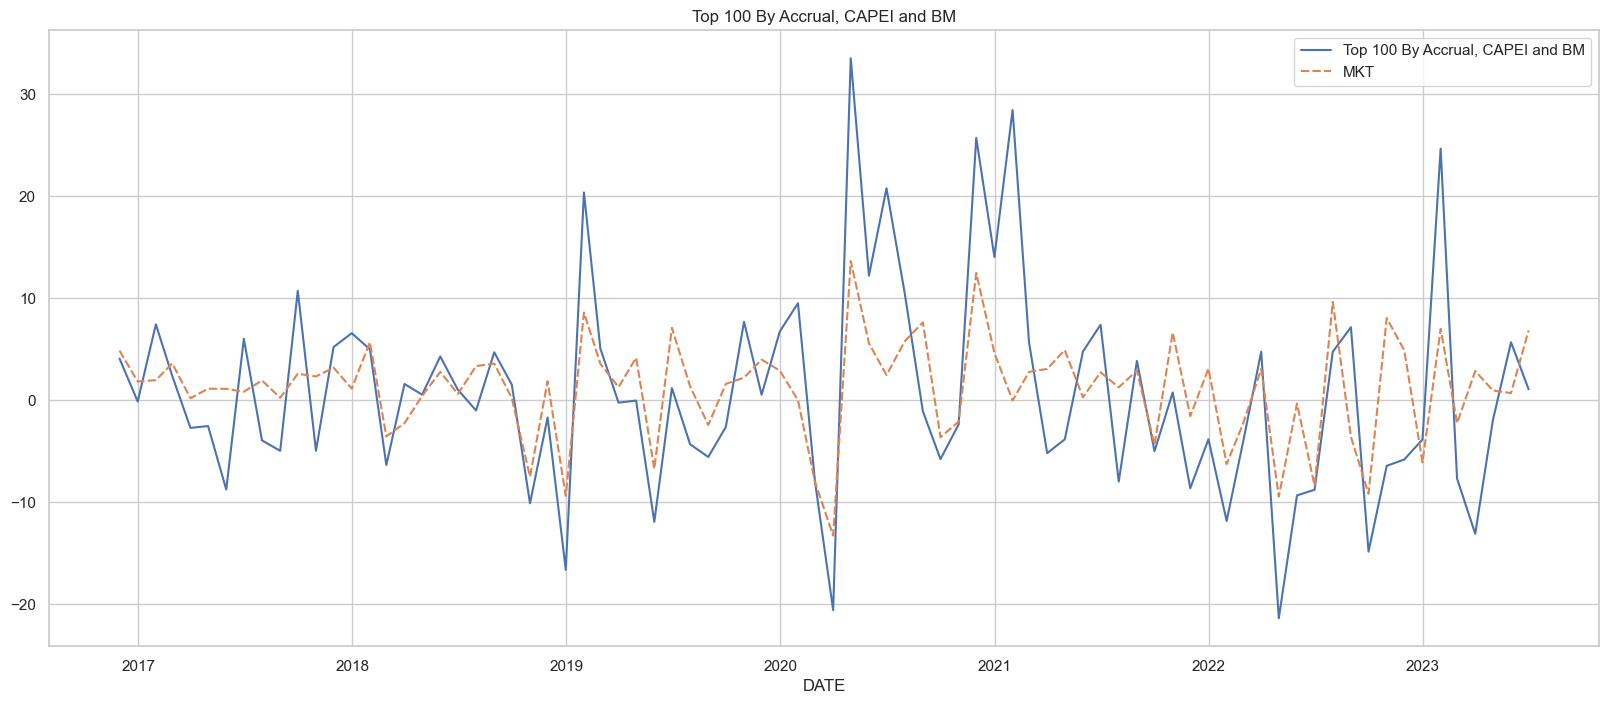

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(20,8))
sns.lineplot(data = ret.iloc[-80:, [-4, -2]] * 100)
plt.title(returns.iloc[-2, 0])
plt.show()

In [ ]:
ret

,"Top 100 By accrual, profitability, solvency, ROA, EV multiple","Top 100 By accraul, solvency, roa, profitability, EV multiple","Top 100 By accraul, roa, profitability, solvency, EV multiple","Top 100 By profitability, solvency, roa, accraul, EV multiple","Top 100 By Accrual, capital ratio and cash ratio","Top 100 By Cash Ratio, Capital Ratio and Accrual","Top 100 By Accrual, CAPEI and BM","Top 100 By Accrual, Gprof, Investment_act, At_turn",MKT,RF
DATE,,,,,,,,,,
2000-01-31,0.191175,0.165127,0.174147,0.019072,0.265822,0.184419,0.374330,0.172724,-0.0433,0.0041
2000-02-29,0.216661,0.192043,0.183248,0.149811,0.561029,0.575590,0.376845,0.204530,0.0288,0.0043
2000-03-31,0.008774,0.017446,0.007495,0.048307,-0.138281,-0.013227,-0.075521,-0.027753,0.0567,0.0047
2000-04-30,-0.163466,-0.168527,-0.184591,-0.054734,-0.272401,-0.218859,-0.235865,-0.207214,-0.0594,0.0046
2000-05-31,-0.066750,-0.080031,-0.077664,-0.018027,-0.132780,-0.114235,-0.178490,-0.152391,-0.0392,0.0050
...,...,...,...,...,...,...,...,...,...,...
2023-02-28,-0.048270,-0.026400,-0.026512,-0.039849,-0.103574,-0.085762,-0.076787,-0.019099,-0.0224,0.0034
2023-03-31,-0.095203,-0.065158,-0.115468,-0.037299,-0.123956,-0.128143,-0.130864,-0.062618,0.0287,0.0036
2023-04-30,-0.098983,-0.070109,-0.067913,-0.000949,-0.036635,-0.020030,-0.019739,-0.041853,0.0096,0.0035


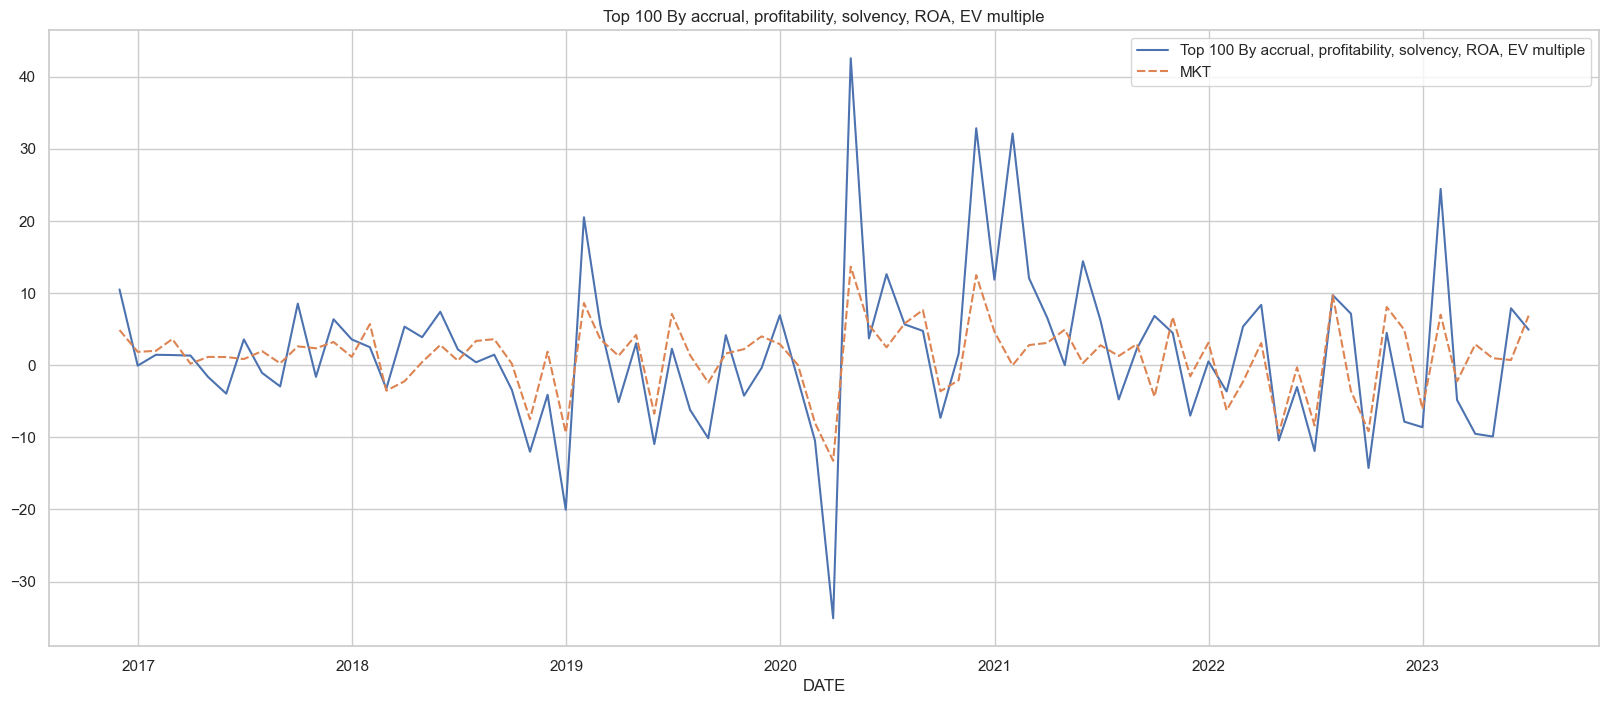

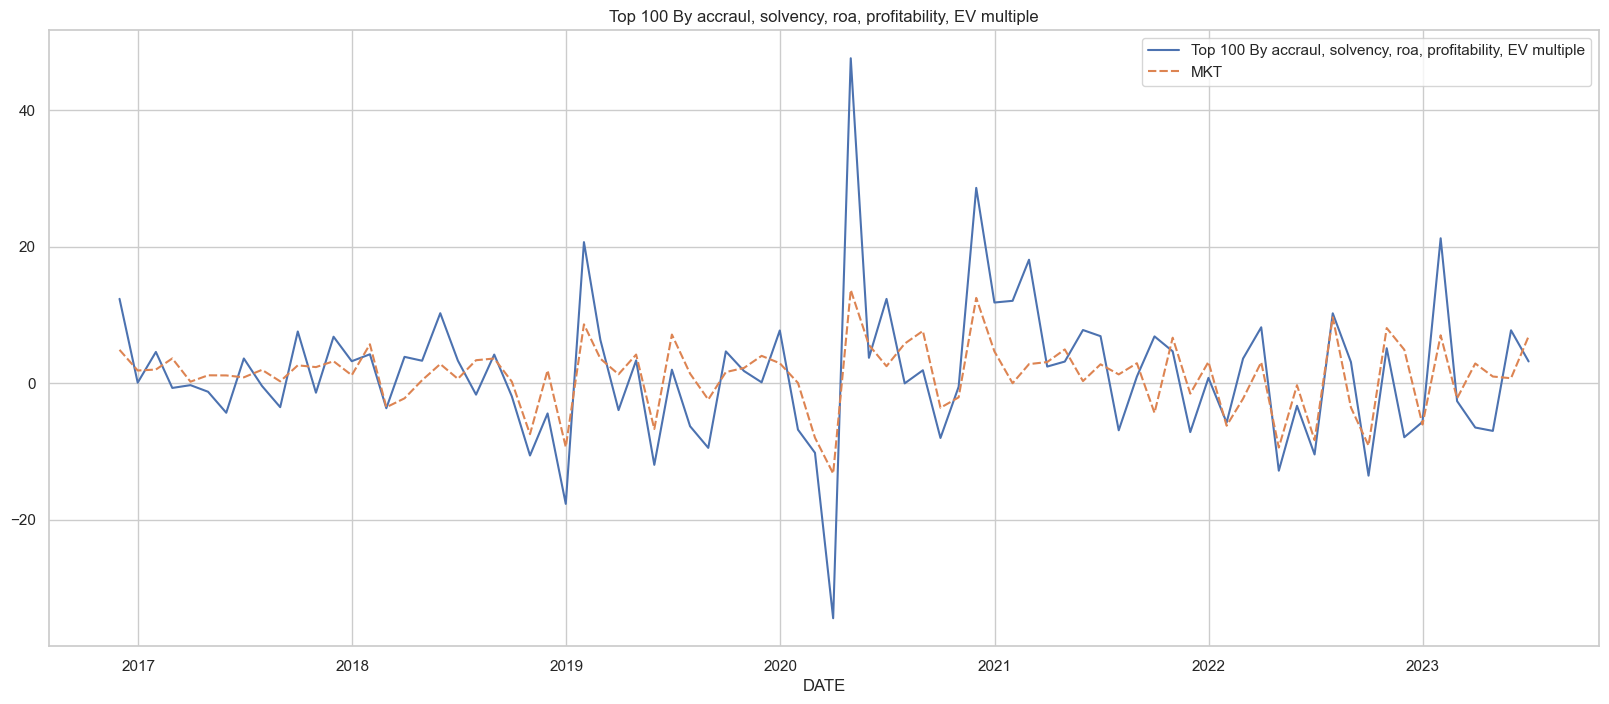

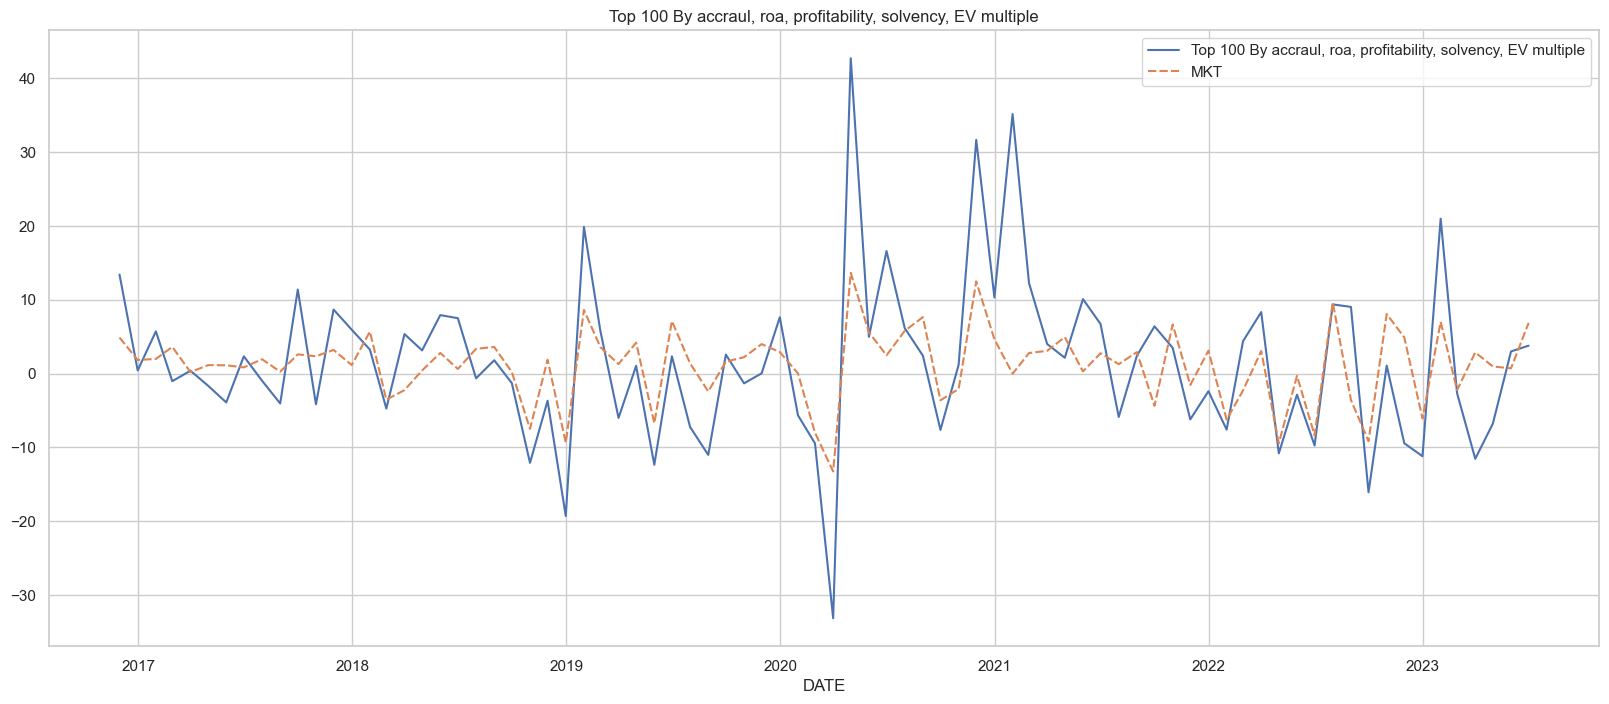

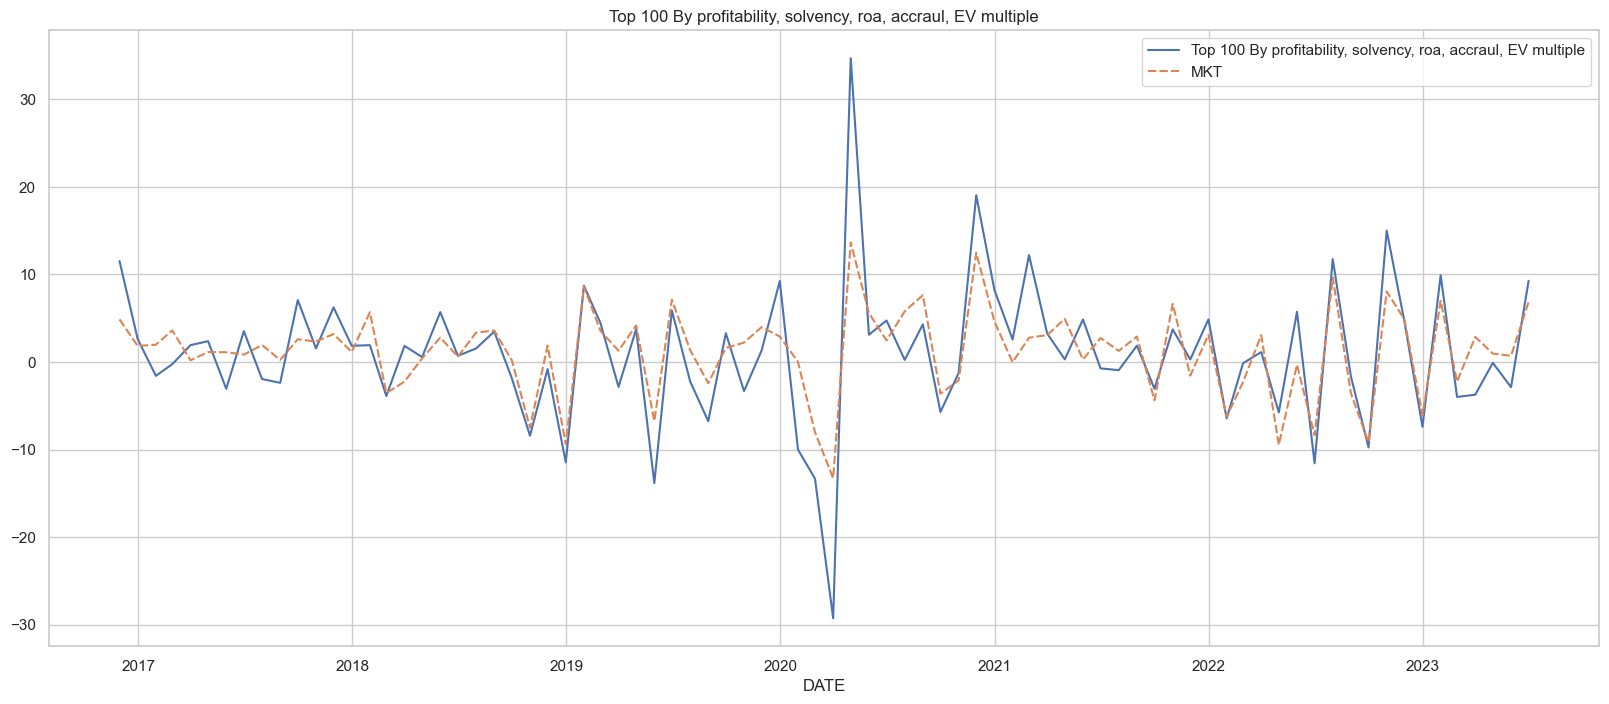

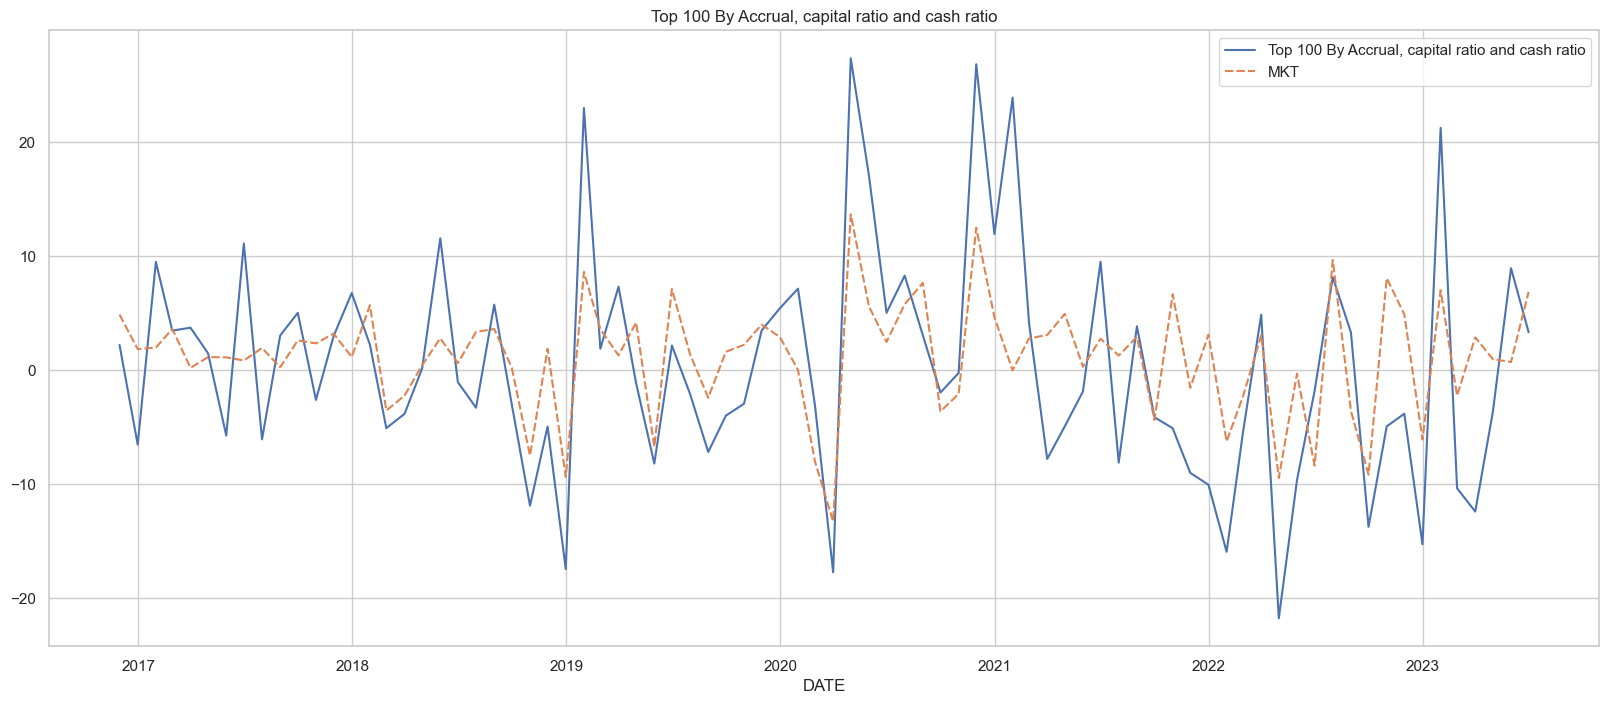

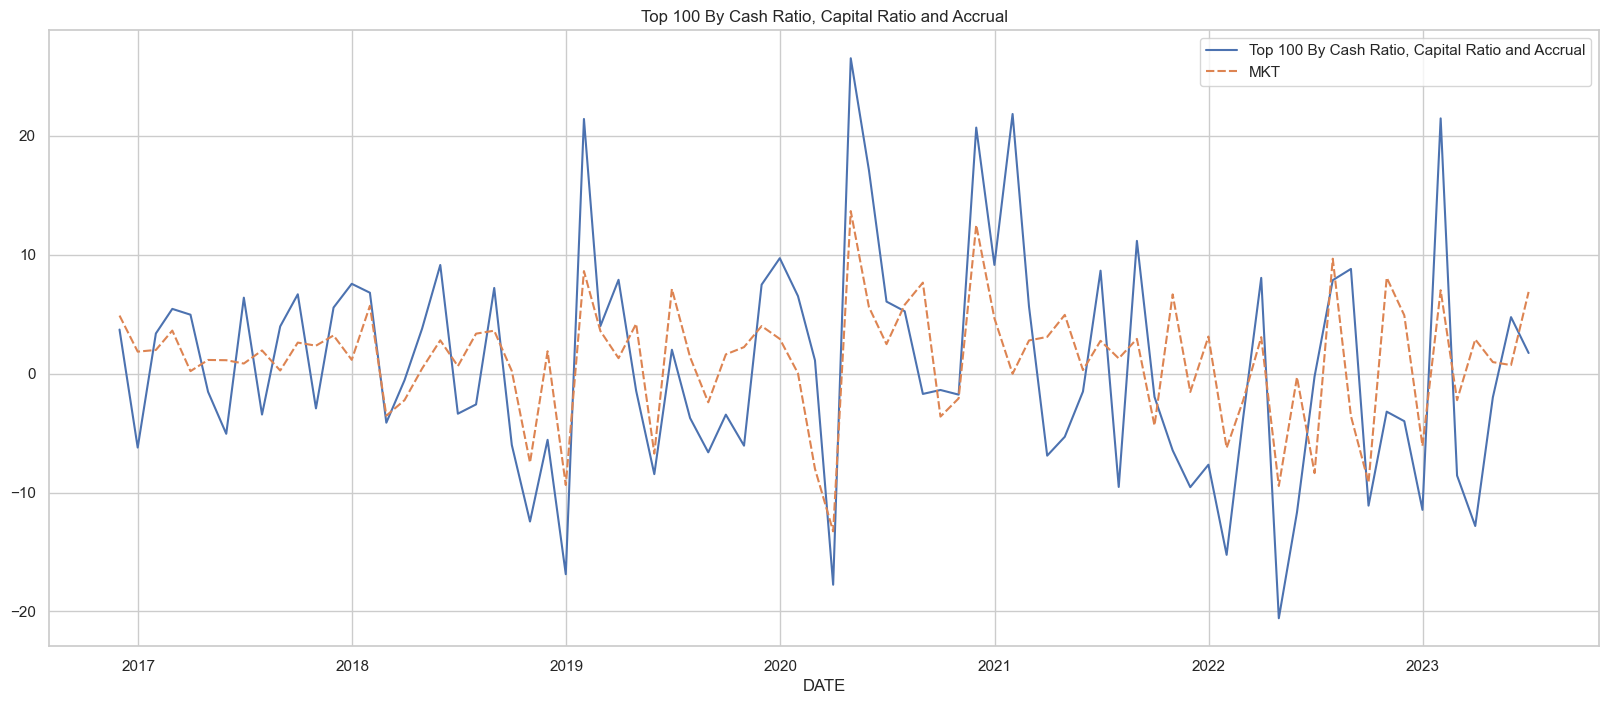

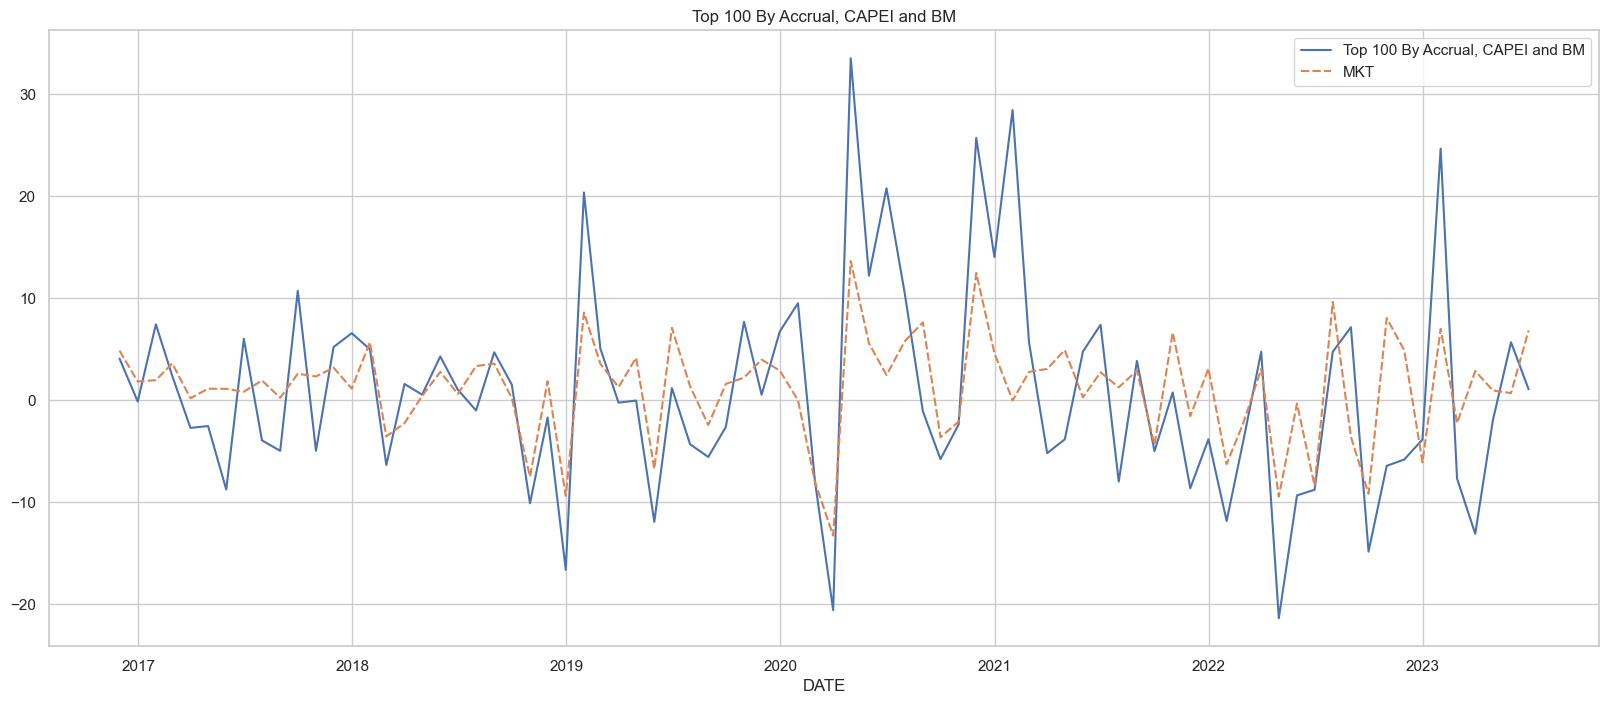

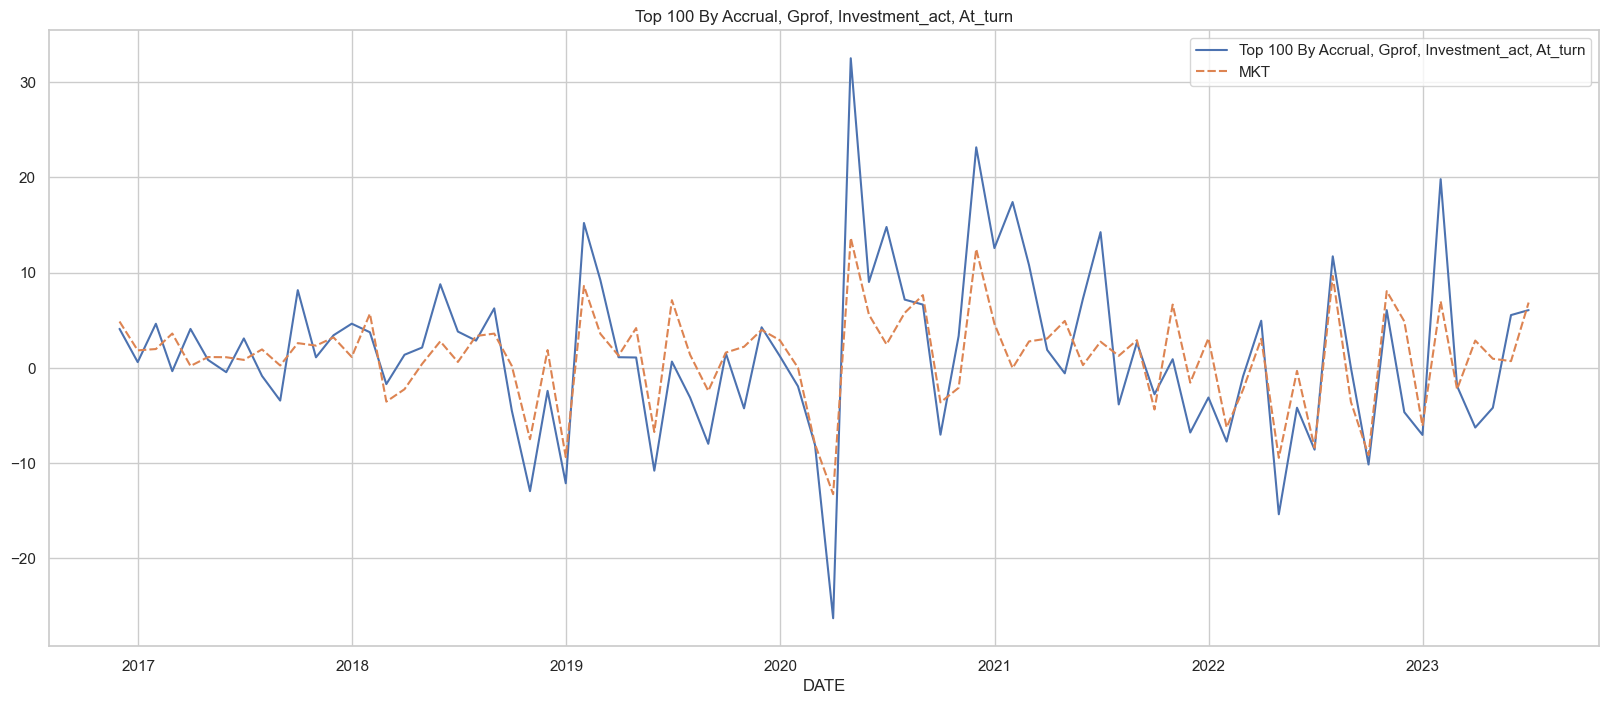

In [ ]:
for i in range(len(returns)):
    sns.set(style="whitegrid")
    plt.figure(figsize=(20,8))
    sns.lineplot(data = ret.iloc[-80:, [i, -2]] * 100)
    plt.title(returns.iloc[i, 0])
    plt.show()

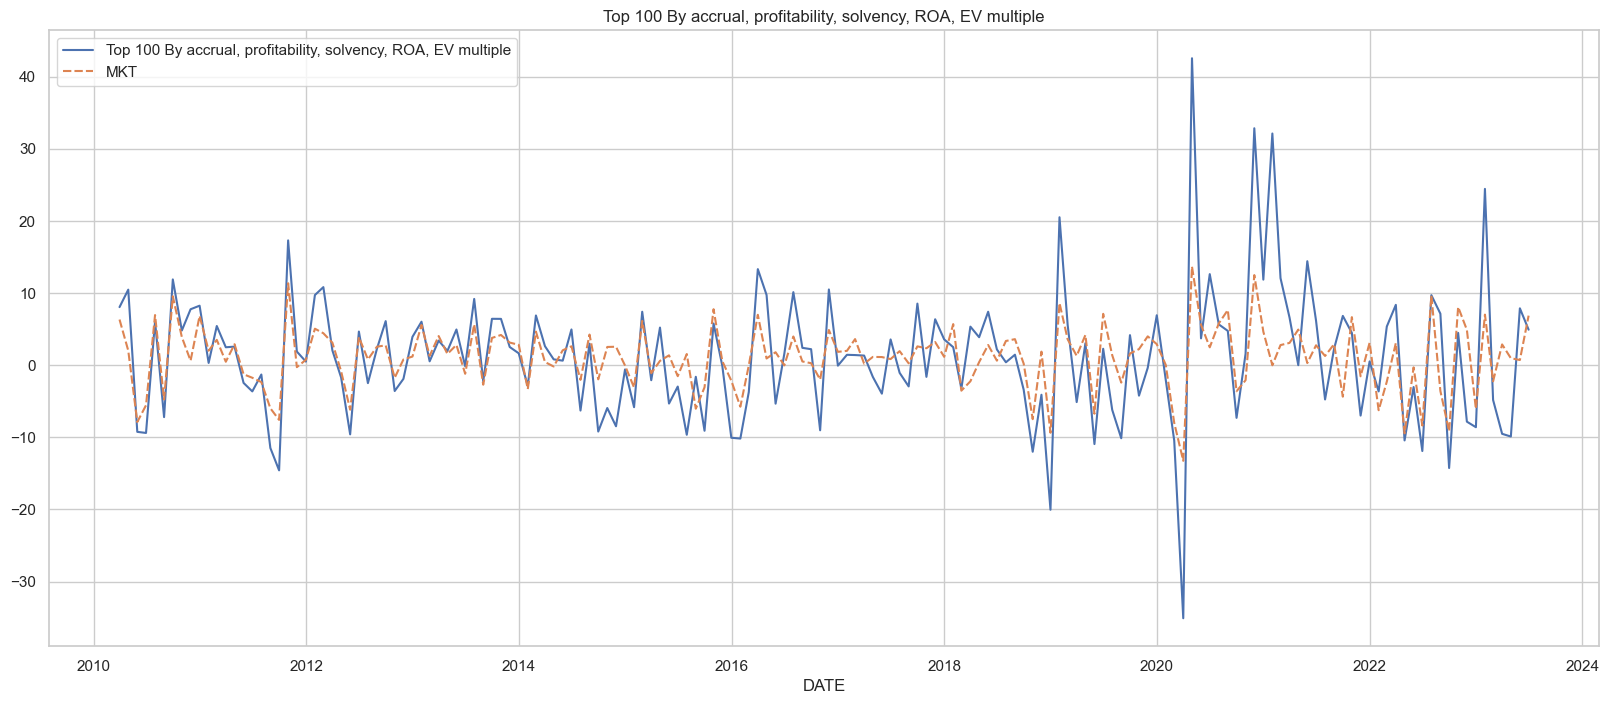

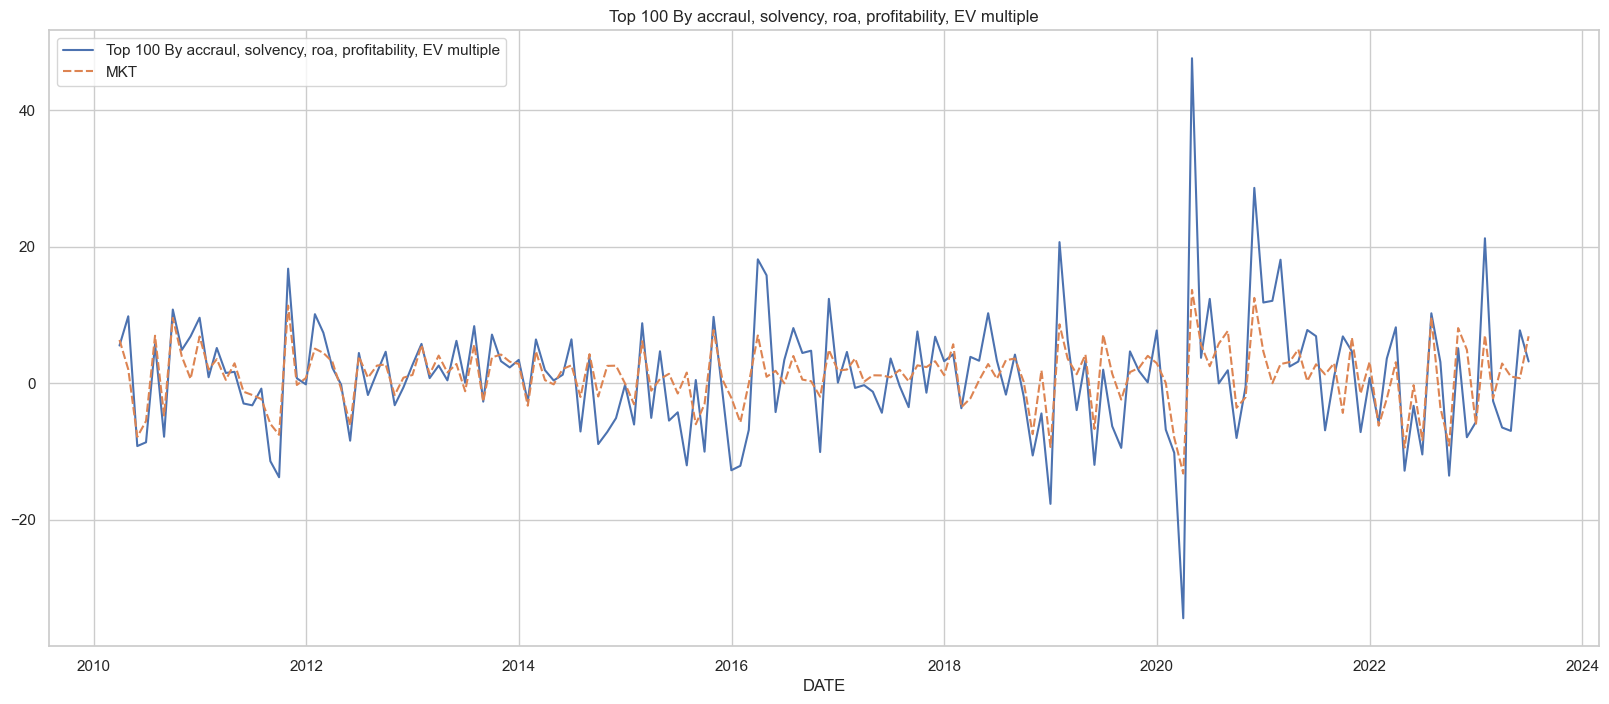

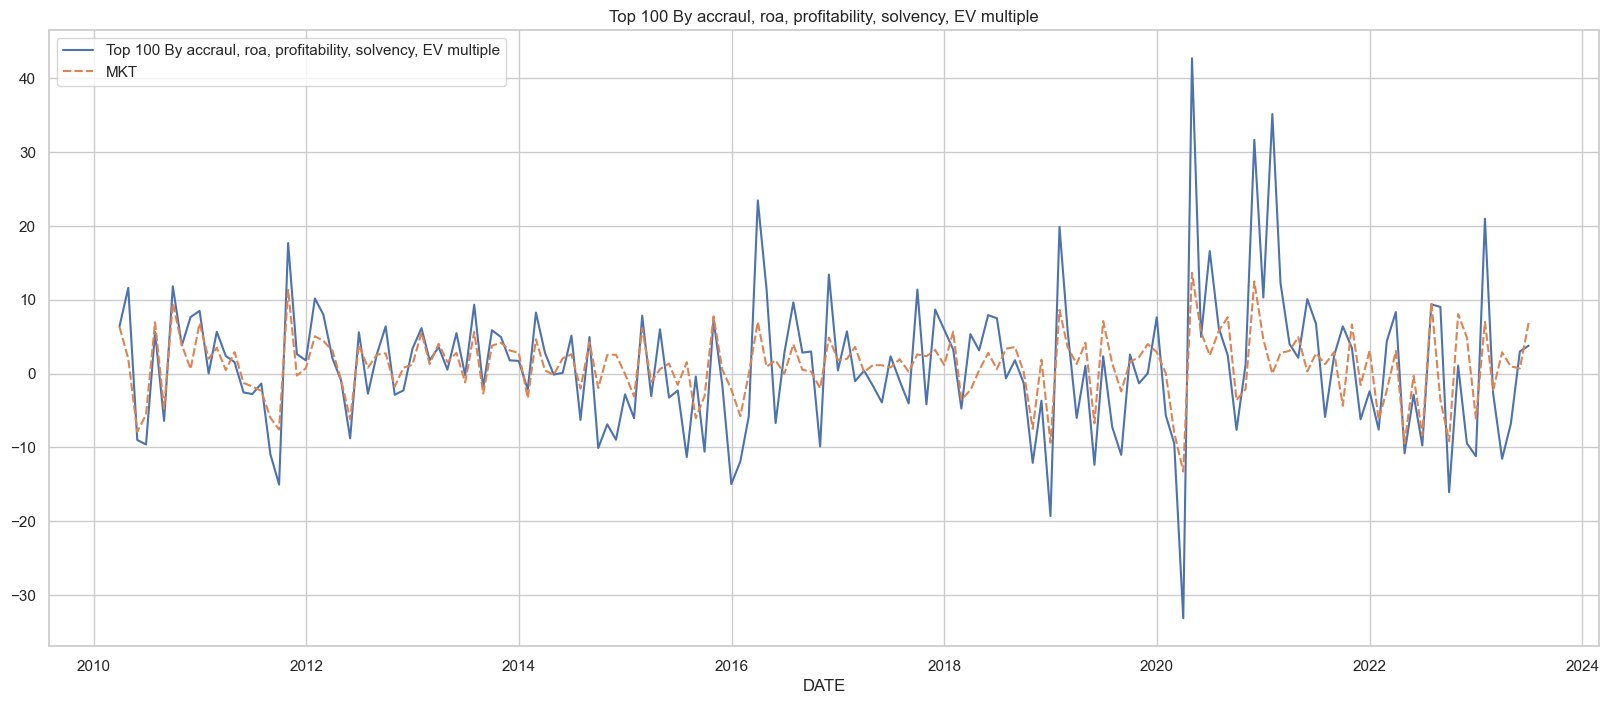

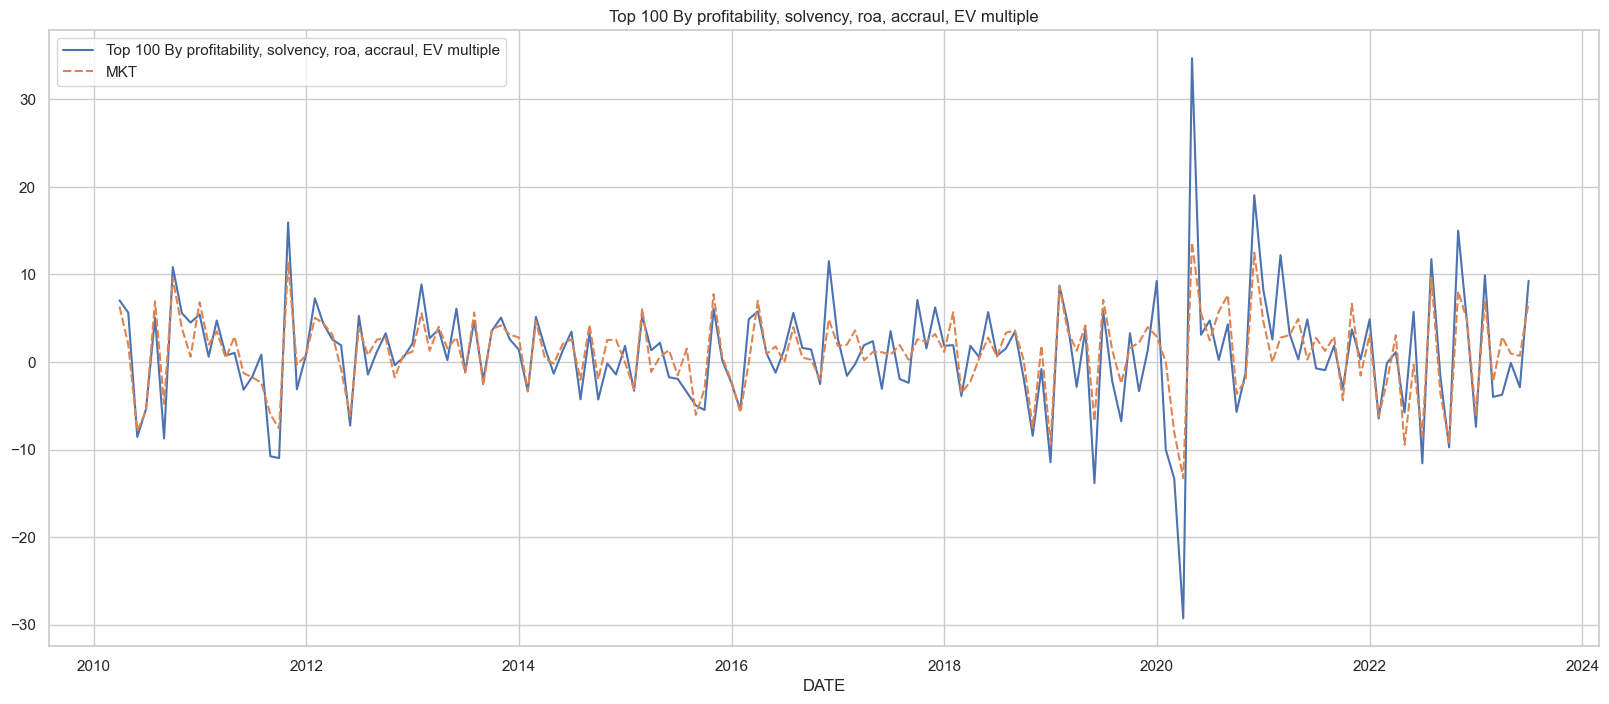

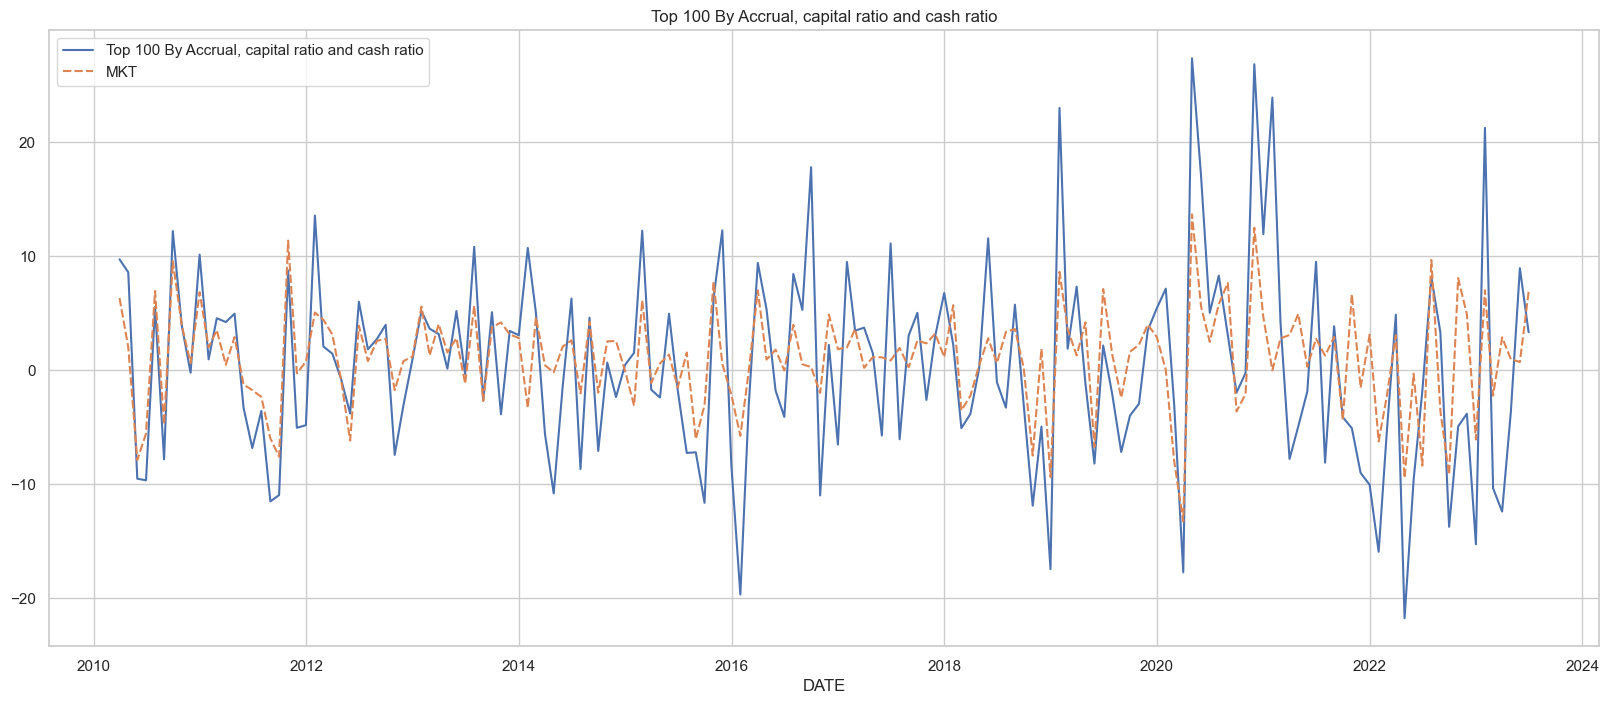

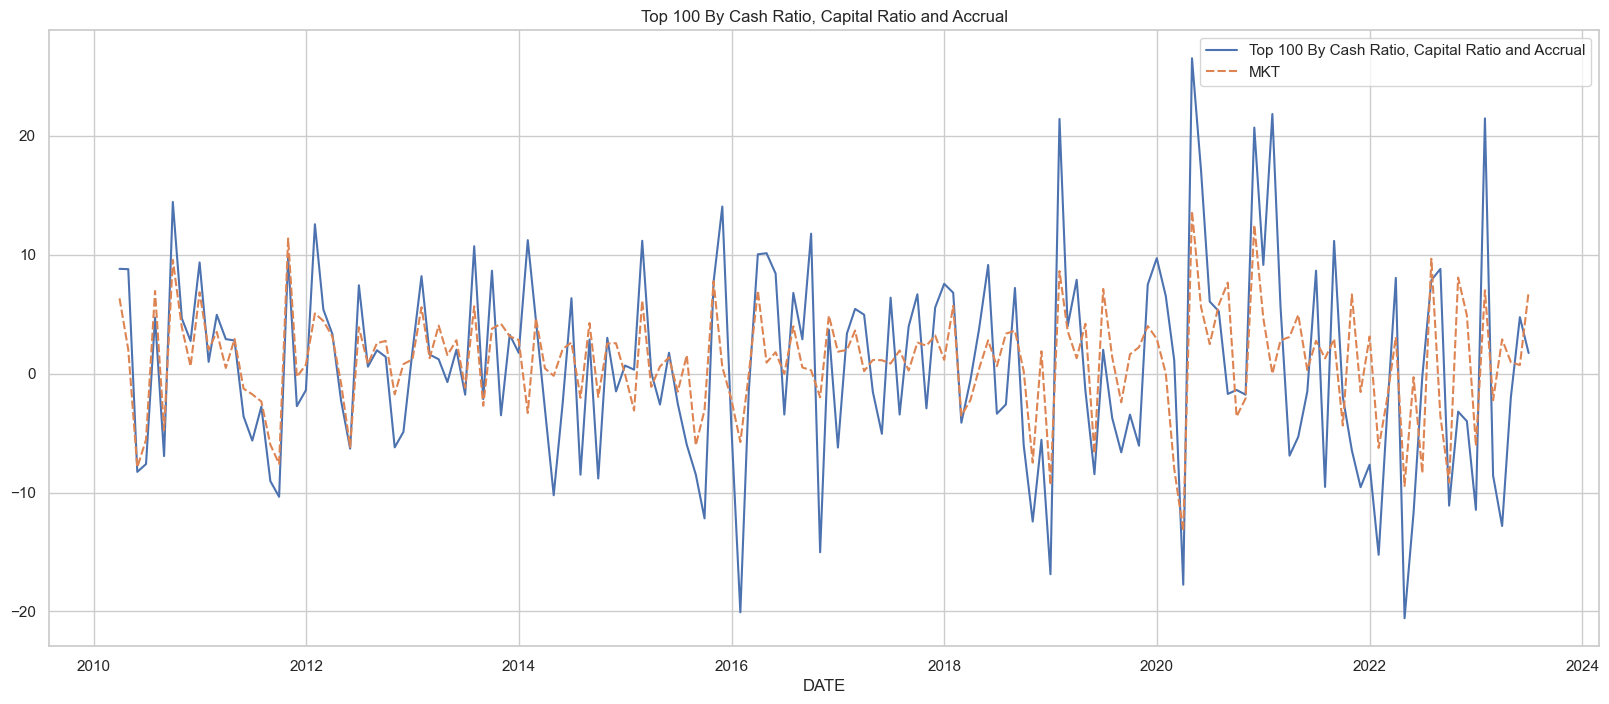

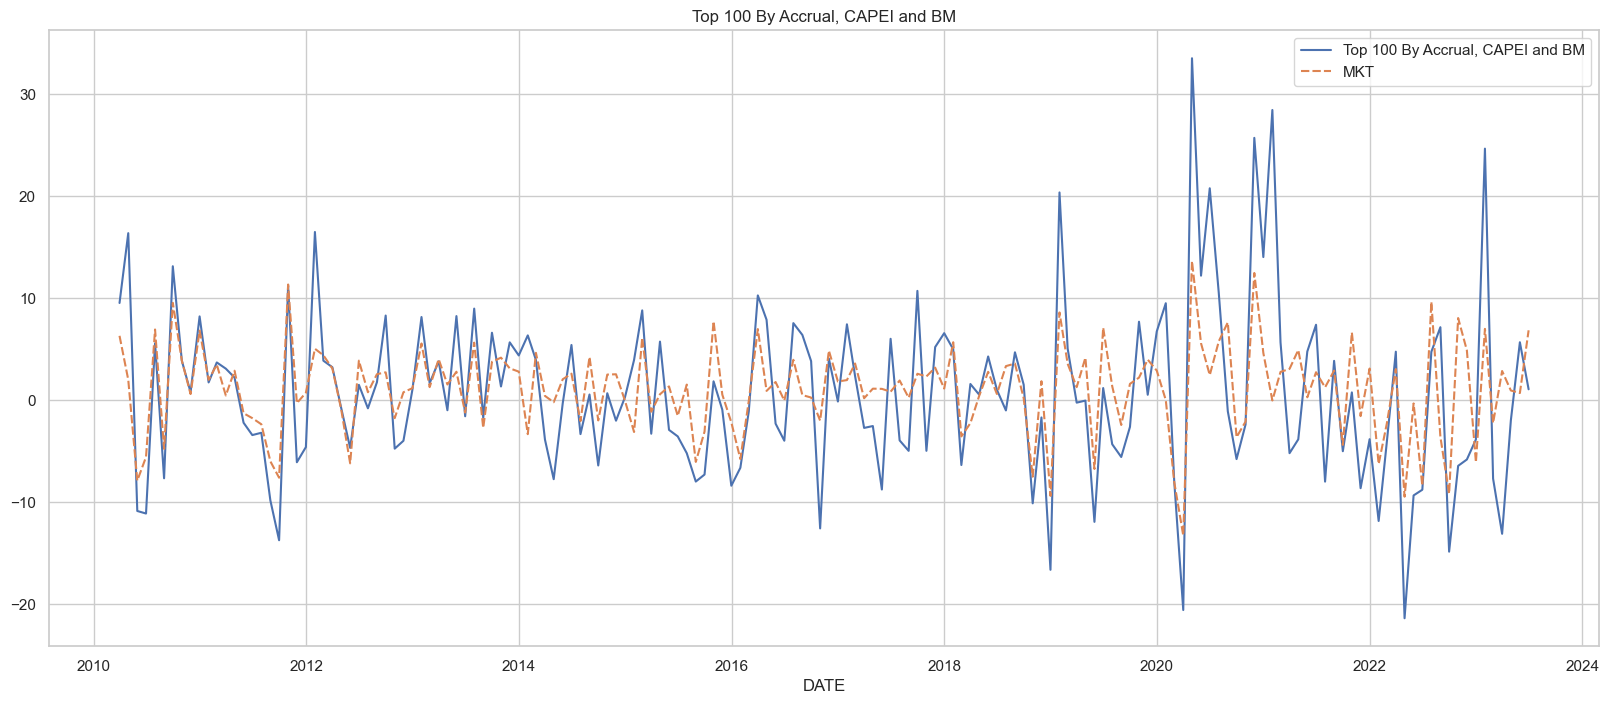

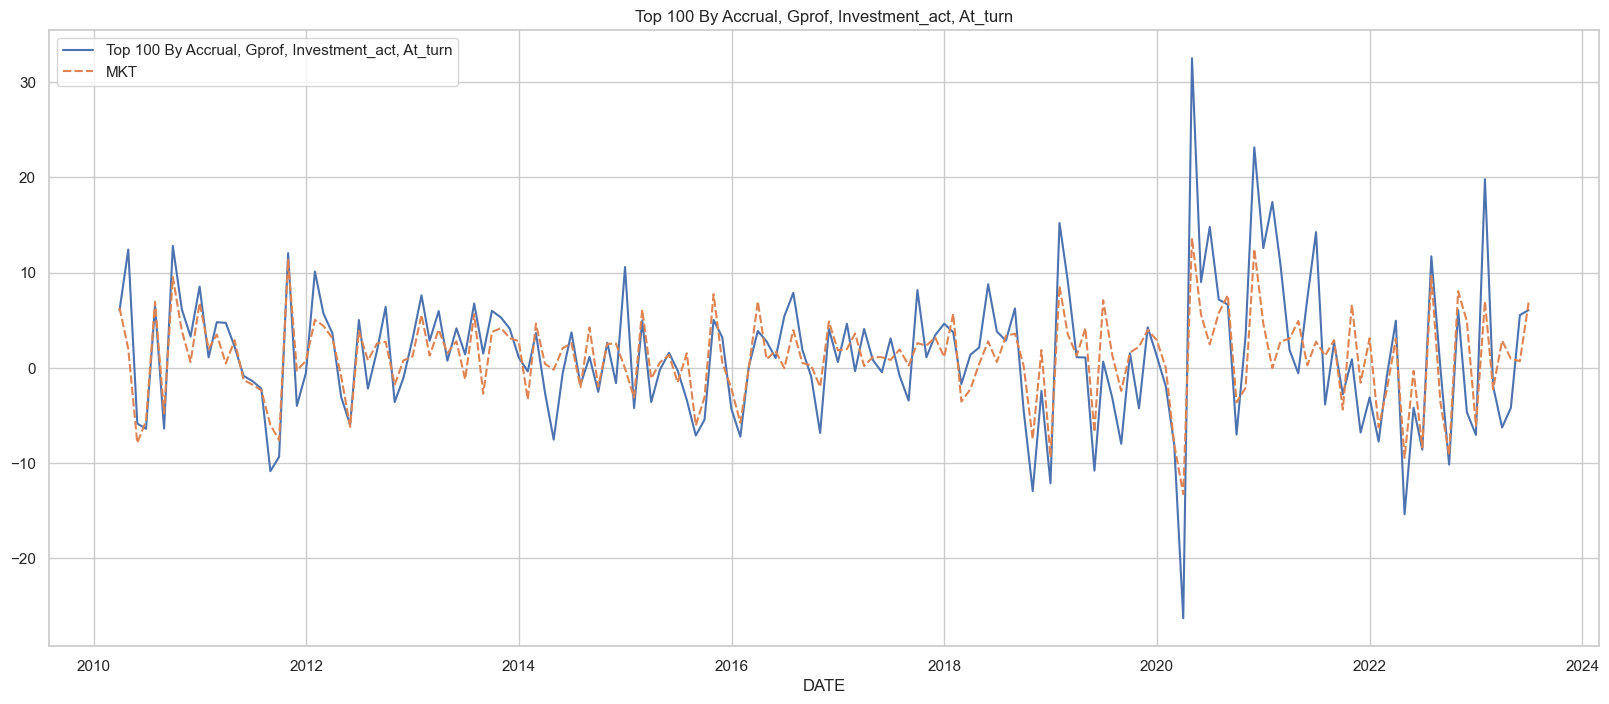

In [ ]:
for i in range(len(returns)):
    sns.set(style="whitegrid")
    plt.figure(figsize=(20,8))
    sns.lineplot(data = ret.iloc[-160:, [i, -2]] * 100)
    plt.title(returns.iloc[i, 0])
    plt.show()